In [175]:
import numpy as np
import matplotlib.pyplot as plt 
from minisom import MiniSom    


(25, 3)
Star ID:  0.0 , lat: 349.752999935431 , len:  35.81842332411296
Star ID:  1.0 , lat: 58.7404644497268 , len:  83.89202144991368
Star ID:  2.0 , lat: 89.74133638001315 , len:  159.09212230086504
Star ID:  3.0 , lat: 246.2665946604424 , len:  325.1653603946849
Star ID:  4.0 , lat: 45.147758827740766 , len:  184.0777418456264


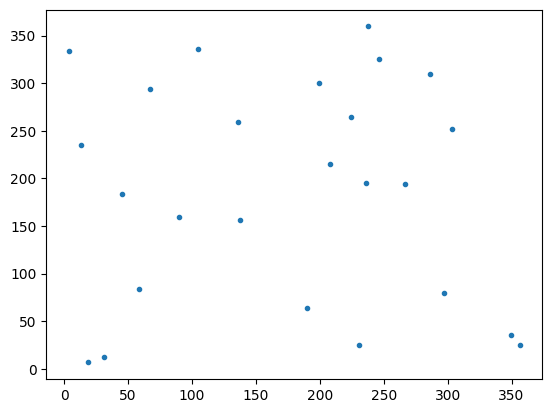

In [210]:
#  Create a set of 25*25 random stars in range [360,360]
n_stars = 25

# Create the set of points
x = np.random.uniform(0, 360, n_stars)
y = np.random.uniform(0, 360, n_stars)
stars_id = np.linspace(0,n_stars-1,n_stars, dtype=int)

stars_data = np.array( np.transpose([x,y, stars_id]))

print(stars_data.shape)

for i in range(5):
    print("Star ID: ", stars_data[i][2], ", lat:", stars_data[i][0], ", len: ", stars_data[i][1])

plt.figure()
plt.plot(x,y,'.')
plt.show()

In [244]:
from scipy.spatial import KDTree

# Create the k-d tree
tree = KDTree(stars_data[:,:2])

n_of_neighbor = 4

# Find the 5 closest neighbors for each poin
distances, indices = tree.query(stars_data[:,:2], k=n_of_neighbor+1)

features_vec = []

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][2], "(","%0.2f" % stars_data[i][0],",","%0.2f" %stars_data[i][1],")")
    features = []
    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        x_distance = stars_data[neighbor_index][0] - stars_data[i][0]
        y_distance = stars_data[neighbor_index][1] - stars_data[i][1]
        print("Neighbor ID:", stars_data[neighbor_index][2], "(","%0.2f" %stars_data[neighbor_index][0],",","%0.2f" %stars_data[neighbor_index][1],")", ", x-distance:", x_distance, ", y-distance:", y_distance)
        # features.append(np.array(stars_data[neighbor_index][0] * stars_data[i][0] 
        #                 + stars_data[neighbor_index][1] * stars_data[i][1]) )
        features.append(x_distance)
        features.append(y_distance)
    print("Number of features: ",len(features))
    features_vec.append(features)

Star ID: 0.0 ( 349.75 , 35.82 )
Neighbor ID: 8.0 ( 356.28 , 24.62 ) , x-distance: 6.527125108156838 , y-distance: -11.196934918164931
Neighbor ID: 12.0 ( 296.83 , 79.71 ) , x-distance: -52.92050489141758 , y-distance: 43.887740384229865
Neighbor ID: 19.0 ( 230.78 , 24.98 ) , x-distance: -118.9714889919791 , y-distance: -10.83532475725045
Neighbor ID: 24.0 ( 189.69 , 64.23 ) , x-distance: -160.0613729793433 , y-distance: 28.414152910131328
Number of features:  8
Star ID: 1.0 ( 58.74 , 83.89 )
Neighbor ID: 21.0 ( 31.02 , 12.74 ) , x-distance: -27.71843915460449 , y-distance: -71.15144031573266
Neighbor ID: 2.0 ( 89.74 , 159.09 ) , x-distance: 31.00087193028635 , y-distance: 75.20010085095136
Neighbor ID: 11.0 ( 18.98 , 6.67 ) , x-distance: -39.755467447340166 , y-distance: -77.21735960821
Neighbor ID: 4.0 ( 45.15 , 184.08 ) , x-distance: -13.592705621986035 , y-distance: 100.18572039571272
Number of features:  8
Star ID: 2.0 ( 89.74 , 159.09 )
Neighbor ID: 18.0 ( 137.59 , 156.63 ) , x-di

In [179]:
# star_features = np.random.rand(625, 4)



In [245]:
import numpy as np
from minisom import MiniSom

# Assuming you have a dataset of star features named star_features with shape (500, 4)
# star_features = np.random.rand(500, 4)
features_vec = np.array(features_vec) # Transform to array
star_features = features_vec

# Normalize the data
star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))

# Define the SOM parameters
som_rows = 5
som_columns = 5
input_len = star_features.shape[1]

# Initialize the SOM
som = MiniSom(som_rows, som_columns, input_len, sigma=1.0, learning_rate=0.7, neighborhood_function='gaussian')
# Train the SOM
som.train_random(data=star_features_normalized, num_iteration=100000, verbose= True)


 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.04663308292248918


Predicted Star ID: 4, actual star ID: 3


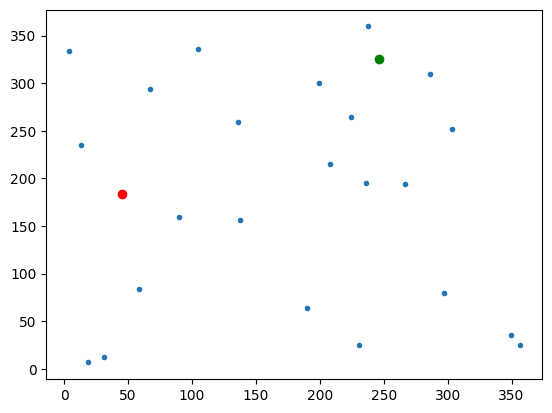

In [246]:

# Create a dictionary to store the star ID for each grid position
star_ids = {tuple(map(int, pos)): star_id for pos, star_id in zip(som.win_map(star_features_normalized), range(1, len(star_features_normalized) + 1))}

# Define a function to predict the star ID for a given feature vector
def predict_star_id(feature_vector):
    normalized_feature = (feature_vector - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    winner = som.winner(normalized_feature)
    return star_ids[tuple(map(int, winner))]

# Test the prediction for a sample feature vector
random_id = np.random.randint(0,25)
sample_feature_vector = features_vec[random_id] 
predicted_star_id = predict_star_id(sample_feature_vector)
print(f"Predicted Star ID: {predicted_star_id}, actual star ID: {random_id}")


plt.figure()
plt.plot(x,y,'.')
plt.plot(stars_data[predicted_star_id][0],stars_data[predicted_star_id][1],'or')
plt.plot(stars_data[random_id][0],stars_data[random_id][1],'og')
plt.show()
